In [1]:
#ignore sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display

In [3]:
import sklearn
sklearn.__version__

'1.4.2'

In [4]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))
        
def plot_gmm(gmm, X, ax, label=True):
    color=np.array(['red', 'purple', 'orange'])
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=color[labels], s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=0.3)

### Generate some data points

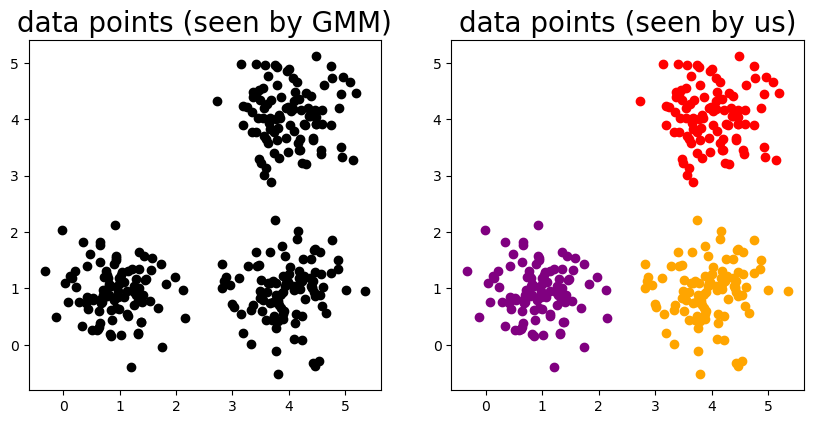

In [5]:
#%% create a random number generator
rng = np.random.RandomState(0)
#%% generate some data samples (three groups) in 2D space
#group1: M data samples
M=100 # change to 100
sigma=0.5 # try 0.5, 1, and 2(overlapping clusters)
X1 = sigma*rng.randn(M,2)
X1 += [4, 4] #center of group1
#group2: M data samples
X2 = sigma*rng.randn(M,2)
X2 += [1, 1] #center of group2
#group3: M data samples
X3 = sigma*rng.randn(M,2)
X3 += [4, 1] #center of group3
#put data in one 2D array
X = np.concatenate([X1, X2, X3], axis=0)
#
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].plot(X1[:,0], X1[:,1], 'ko')
ax[0].plot(X2[:,0], X2[:,1], 'ko')
ax[0].plot(X3[:,0], X3[:,1], 'ko')
ax[0].set_aspect('equal')
ax[0].set_title('data points (seen by GMM)', fontsize=20)
ax[1].plot(X1[:,0], X1[:,1], 'o', color='red')
ax[1].plot(X2[:,0], X2[:,1], 'o', color='purple')
ax[1].plot(X3[:,0], X3[:,1], 'o', color='orange')
ax[1].set_aspect('equal')
ax[1].set_title('data points (seen by us)', fontsize=20)
plt.draw()

### Step-1:  set the number of Gaussians and  initialize the parameters

Text(0.5, 1.0, 'Initialization')

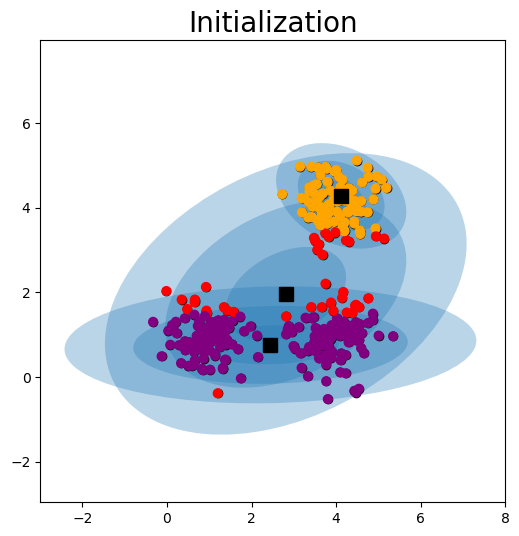

In [6]:
from sklearn.mixture import GaussianMixture
init_method='' # '' or 'kmeans'
#-----------------------------
if init_method == 'kmeans':
    #initialization using kmeans
    gmm=GaussianMixture(n_components=3, max_iter=1, n_init=1,
                        init_params='kmeans', warm_start=True)
else:
    #random initialization
    means_init = 6*rng.rand(3,2)
    gmm=GaussianMixture(n_components=3, max_iter=1, n_init=1,
                        means_init=means_init,
                        init_params='kmeans', warm_start=True)
#-----------------------------
gmm.fit(X)
means_init=gmm.means_
#----------------------------------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(X[:,0], X[:,1], 'ko')
plot_gmm(gmm, X, ax)
s=['ks', 'ks', 'ks']
for k in range(0, 3):
    ax.plot(means_init[k,0], means_init[k,1], s[k], markersize=10)
ax.axis([-3, 8, -3, 8])
ax.set_aspect('equal')
ax.set_title('Initialization', fontsize=20)

In [7]:
gmm

GaussianMixture(max_iter=1,
                means_init=array([[3.40930556, 1.47934164],
       [3.57859839, 0.70515386],
       [5.85530321, 5.59536722]]),
                n_components=3, warm_start=True)

### Update the parameters and soft assignment matrix in a loop

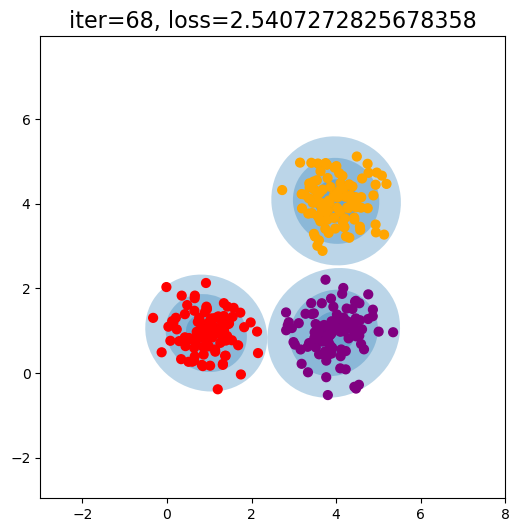

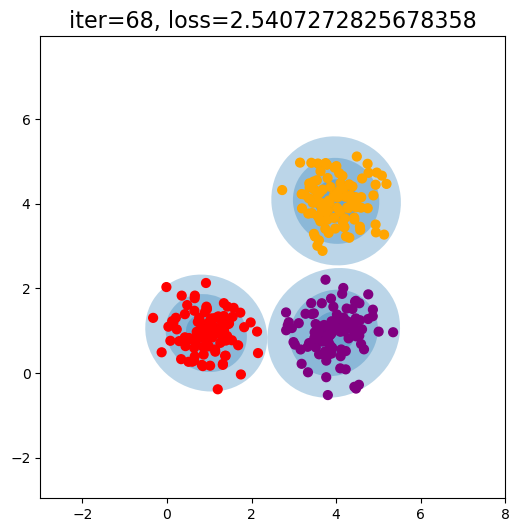

change in loss < 1e-16, break
Elapsed time is 160.033665 seconds 



In [8]:
loss_list=[]
tic = time.time() # time recorder
for iter in range(0, 100):
    gmm.fit(X)
    means=gmm.means_
    label=gmm.predict(X)
    loss=-gmm.score(X)
    loss_list.append(loss)
    if len(loss_list) > 1:
        if abs(loss_list[-1]-loss_list[-2])<1e-16:
            print('change in loss < 1e-16, break')
            break
    fig, ax = plt.subplots(figsize=(6,6))
    plot_gmm(gmm, X, ax)
    s=['ks', 'ks', 'ks']
    #for k in range(0, 3):
    #    ax.plot(gmm.means_[k,0], gmm.means_[k,1], s[k], markersize=10)
    ax.set_title('iter='+str(iter)+', loss='+str(loss), fontsize=16)
    ax.axis([-3, 8, -3, 8])
    ax.set_aspect('equal')
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(2)
    plt.close(fig)
toc = time.time()
print('Elapsed time is %f seconds \n' % float(toc - tic)) 

### plot the loss values over many iterations

Text(0, 0.5, 'Loss')

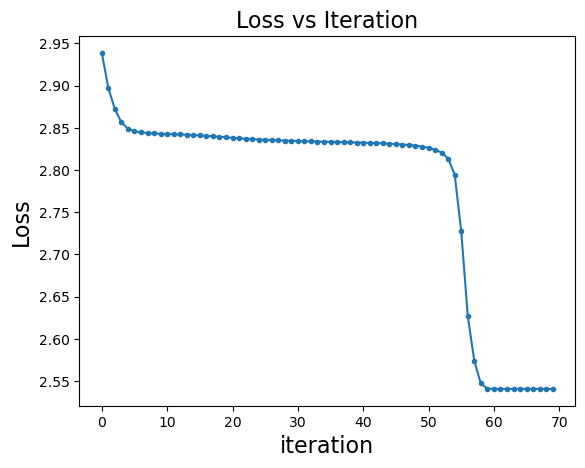

In [9]:
fig, ax = plt.subplots()
ax.plot(loss_list, '.-')
ax.set_title('Loss vs Iteration', fontsize=16)
ax.set_xlabel('iteration', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)